<a href="https://colab.research.google.com/github/Alevtina529/test/blob/main/finn_project_skf_HEC_ipynb%22.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#1. Постановка задачи

Прогноз расхода энергии по временным рядам

С их помощью можно построить модель временных рядов, чтобы прогнозировать энергетический расход. Кроме того, эти данные пригодятся, чтобы выявить тенденции расходов по времени суток, праздникам и более длительным срокам.

О наборе данных

Почасовые данные о энергопотреблении

Данные о почасовом энергопотреблении указаны в мегаваттах (МВт).

# Знакомство с данными, базовый анализ и расширение данных


In [96]:
# Заранее импортируем модули, которые нам понадобятся для решения задачи:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline

from scipy import stats
from sklearn import linear_model
from sklearn import preprocessing
from sklearn import model_selection
from sklearn import tree
from sklearn import ensemble
from sklearn import metrics
from sklearn import cluster
from sklearn import feature_selection
from statsmodels.tsa.seasonal import seasonal_decompose
import statsmodels.api as sm
from statsmodels.tsa.api import SimpleExpSmoothing

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
cvs='/content/drive/MyDrive/Colab/dataset/Finn/est_hourly.paruqet'
df = pd.read_parquet(cvs)
df

,AEP,COMED,DAYTON,DEOK,DOM,DUQ,EKPC,FE,NI,PJME,PJMW,PJM_Load
Datetime,,,,,,,,,,,,
1998-12-31 01:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,29309.0
1998-12-31 02:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,28236.0
1998-12-31 03:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,27692.0
1998-12-31 04:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,27596.0
1998-12-31 05:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,27888.0
...,...,...,...,...,...,...,...,...,...,...,...,...
2018-01-01 20:00:00,21089.0,13858.0,2732.0,4426.0,18418.0,1962.0,2866.0,9378.0,NaN,44284.0,8401.0,NaN
2018-01-01 21:00:00,20999.0,13758.0,2724.0,4419.0,18567.0,1940.0,2846.0,9255.0,NaN,43751.0,8373.0,NaN
2018-01-01 22:00:00,20820.0,13627.0,2664.0,4355.0,18307.0,1891.0,2883.0,9044.0,NaN,42402.0,8238.0,NaN


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 178262 entries, 1998-12-31 01:00:00 to 2018-01-02 00:00:00
Data columns (total 12 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   AEP       121273 non-null  float64
 1   COMED     66497 non-null   float64
 2   DAYTON    121275 non-null  float64
 3   DEOK      57739 non-null   float64
 4   DOM       116189 non-null  float64
 5   DUQ       119068 non-null  float64
 6   EKPC      45334 non-null   float64
 7   FE        62874 non-null   float64
 8   NI        58450 non-null   float64
 9   PJME      145366 non-null  float64
 10  PJMW      143206 non-null  float64
 11  PJM_Load  32896 non-null   float64
dtypes: float64(12)
memory usage: 17.7 MB


# 2. Очистка данных

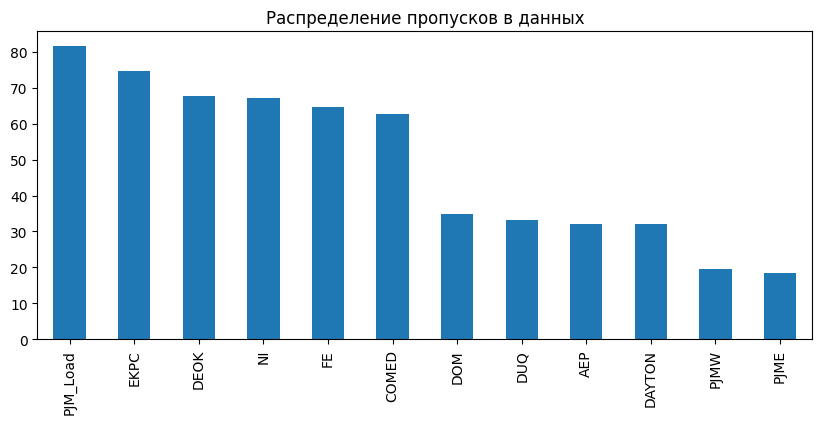

In [47]:
# названия столбцов, где число пропусков больше 0
cols_null_percent = df.isnull().mean() * 100
cols_with_null = cols_null_percent[cols_null_percent>0].sort_values(ascending=False)
cols_with_null.plot(
    kind='bar',
    figsize=(10, 4),
    title='Распределение пропусков в данных'
);

In [6]:
#создаём копию исходной таблицы
combine_data = df.copy()

#отбрасываем столбцы с числом пропусков более 30% (100-70)
n = combine_data.shape[0] #число строк в таблице
thresh = n*0.6
combine_data = combine_data.dropna(thresh=thresh, axis=1)


In [7]:
combine_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 178262 entries, 1998-12-31 01:00:00 to 2018-01-02 00:00:00
Data columns (total 6 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   AEP     121273 non-null  float64
 1   DAYTON  121275 non-null  float64
 2   DOM     116189 non-null  float64
 3   DUQ     119068 non-null  float64
 4   PJME    145366 non-null  float64
 5   PJMW    143206 non-null  float64
dtypes: float64(6)
memory usage: 9.5 MB


In [8]:
#отбрасываем строки с числом пропусков более 2 в строке
m = combine_data.shape[1] #число признаков после удаления столбцов
combine_data = combine_data.dropna(thresh=m-2, axis=0)

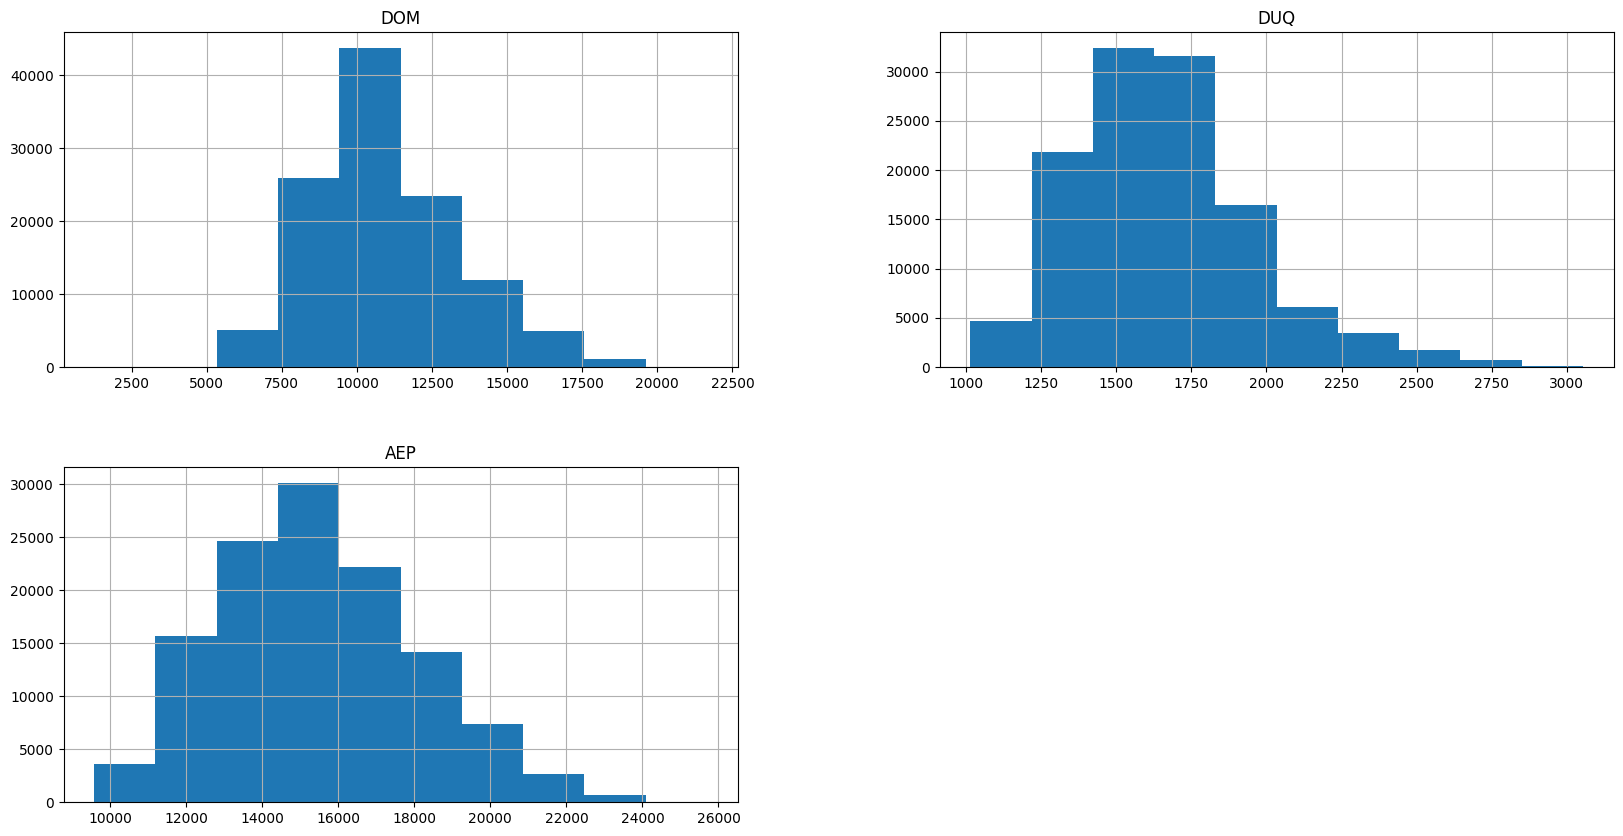

In [48]:
# названия столбцов, где число пропусков больше 0
cols_null_percent = combine_data.isnull().mean() * 100
cols_with_null = cols_null_percent[cols_null_percent>0].sort_values(ascending=False)
cols = cols_with_null.index
combine_data[cols].hist(figsize=(20, 10));

In [262]:
#создаем копию исходной таблицы
data = combine_data.copy()
#создаем словарь имя столбца: число(признак) на который надо заменить пропуски
values = {
    'DOM': data['DOM'].median(),
    'DUQ': data['DUQ'].median(),
    'AEP': data['AEP'].median(),
    'DAYTON': data['DAYTON'].median(),
    'PJMW': data['PJMW'].median(),
    'PJME': data['PJME'].median()
}
#заполняем пропуски в соответствии с заявленным словарем
data = data.fillna(values)
#выводим результирующую долю пропусков
data.isnull().mean()

AEP       0.0
DAYTON    0.0
DOM       0.0
DUQ       0.0
PJME      0.0
PJMW      0.0
dtype: float64

In [263]:
fill_data=data.copy()
fill_data.index = pd.to_datetime(fill_data.index)
# выделяем дату в отдельный столбец
fill_data['Date'] = fill_data.index.date
fill_data

,AEP,DAYTON,DOM,DUQ,PJME,PJMW,Date
Datetime,,,,,,,
2004-12-31 01:00:00,13478.0,1596.0,10501.0,1630.0,27160.0,5285.0,2004-12-31
2004-12-31 02:00:00,12865.0,1517.0,10501.0,1630.0,25791.0,5085.0,2004-12-31
2004-12-31 03:00:00,12577.0,1486.0,10501.0,1630.0,25052.0,4944.0,2004-12-31
2004-12-31 04:00:00,12517.0,1469.0,10501.0,1630.0,24797.0,4916.0,2004-12-31
2004-12-31 05:00:00,12670.0,1472.0,10501.0,1630.0,25026.0,4960.0,2004-12-31
...,...,...,...,...,...,...,...
2018-01-01 20:00:00,21089.0,2732.0,18418.0,1962.0,44284.0,8401.0,2018-01-01
2018-01-01 21:00:00,20999.0,2724.0,18567.0,1940.0,43751.0,8373.0,2018-01-01
2018-01-01 22:00:00,20820.0,2664.0,18307.0,1891.0,42402.0,8238.0,2018-01-01


In [264]:
fill_data['Date'] = pd.to_datetime(fill_data['Date'], format='%Y-%m-%d') # datetime

In [265]:
# выделяем временной период
fill_data = fill_data.loc[(fill_data['Date'] >= '2010-01-01')
                     & (fill_data['Date'] < '2018-08-03')]

In [284]:
fill_data_copy=fill_data.copy() # данные для Prophet

In [266]:
fill_data.sort_values(by='Date')

,AEP,DAYTON,DOM,DUQ,PJME,PJMW,Date
Datetime,,,,,,,
2010-01-01 00:00:00,15116.0,1794.0,10770.0,1526.0,31647.0,5381.0,2010-01-01
2010-01-01 01:00:00,14585.0,1748.0,10273.0,1465.0,30075.0,5143.0,2010-01-01
2010-01-01 02:00:00,14272.0,1728.0,9960.0,1397.0,28907.0,4986.0,2010-01-01
2010-01-01 03:00:00,14065.0,1715.0,9797.0,1353.0,27906.0,4892.0,2010-01-01
2010-01-01 04:00:00,14047.0,1723.0,9715.0,1336.0,27373.0,4814.0,2010-01-01
...,...,...,...,...,...,...,...
2018-08-02 22:00:00,17001.0,2405.0,13312.0,1901.0,41552.0,6325.0,2018-08-02
2018-08-02 00:00:00,14125.0,1924.0,12362.0,1580.0,37158.0,5363.0,2018-08-02
2018-08-02 23:00:00,15964.0,2250.0,12390.0,1789.0,38500.0,5892.0,2018-08-02


In [24]:
pivot=fill_data.pivot_table(
    values='DAYTON',
    index='Date',
    fill_value=0
).round()
pivot

,DAYTON
Date,
2010-01-01,2013.0
2010-01-02,2170.0
2010-01-03,2275.0
2010-01-04,2483.0
2010-01-05,2527.0
...,...
2018-07-29,1739.0
2018-07-30,2026.0
2018-07-31,2051.0


In [25]:
pivot.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3136 entries, 2010-01-01 to 2018-08-02
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   DAYTON  3136 non-null   float64
dtypes: float64(1)
memory usage: 49.0 KB


# Анализ временных рядов

<Axes: xlabel='Date'>

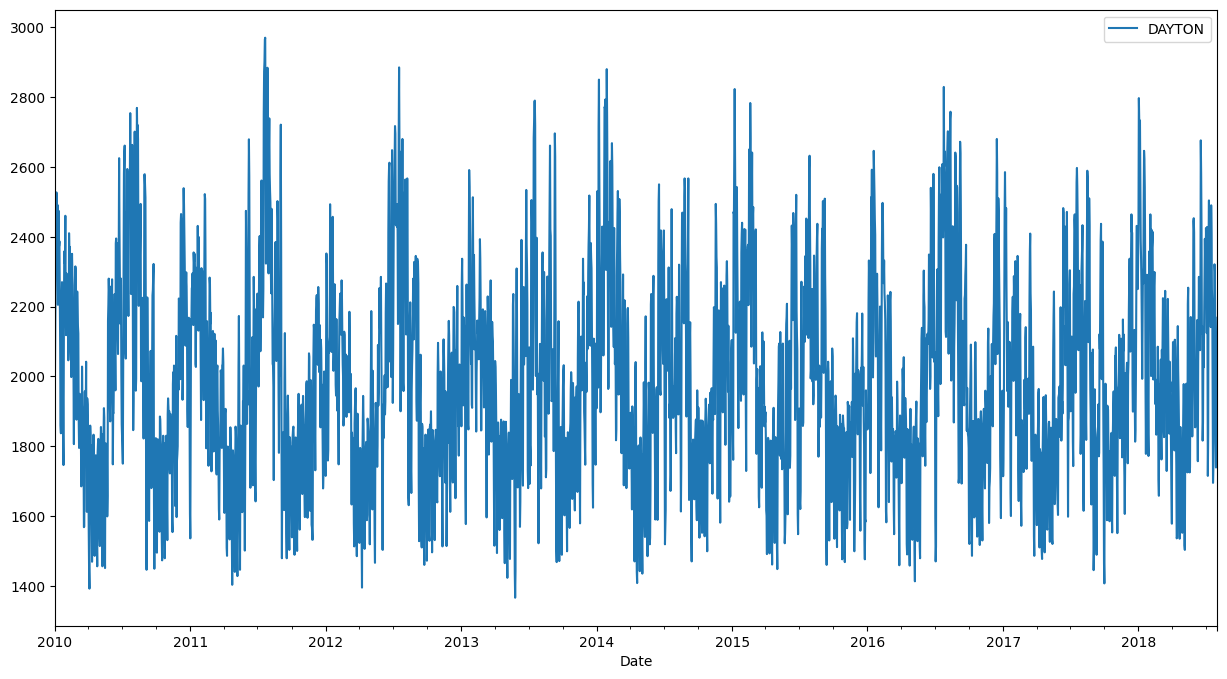

In [88]:
plt.rcParams["figure.figsize"] = 15, 8
pivot.plot()

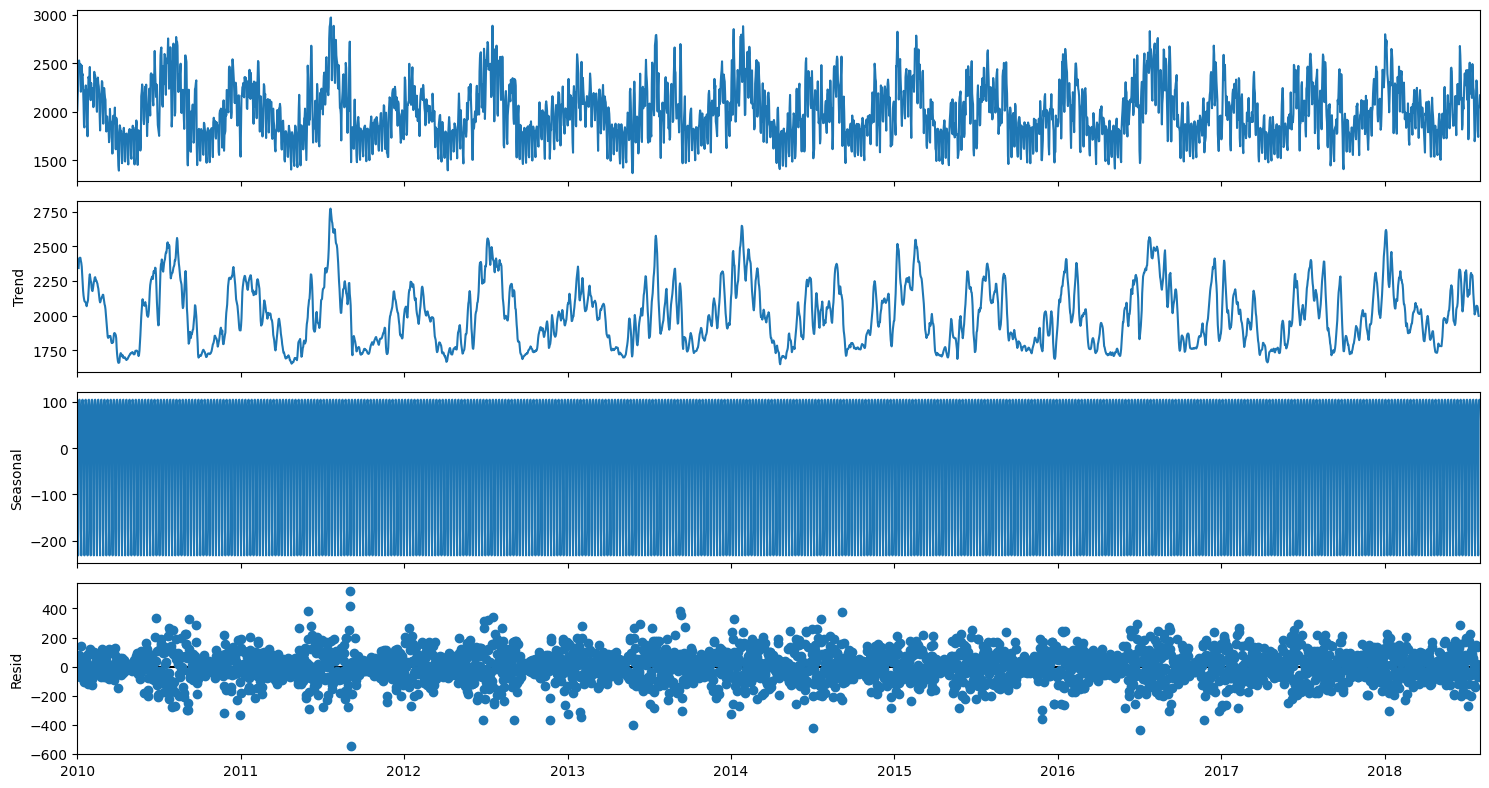

In [89]:
plt.rcParams["figure.figsize"] = 15, 8
decomposition = seasonal_decompose(pivot, model='additive')
decomposition.plot()
pyplot.show()


тренд и сезонность отсутствуют, следовательно ряд стационарен

 # Проверка тестом Дики-Фуллера


Расширенный тест Дики — Фуллера.
В тесте формулируется две гипотезы:

нулевая гипотеза (H0): временной ряд нестационарный, то есть имеет некоторый тренд и сезонную компоненту;

альтернативная гипотеза (H1): временной ряд стационарный, то есть не имеет тренда и сезонной компоненты, и данные скорее случайны.

In [77]:
def stat_test(df):
    test = sm.tsa.adfuller(df)
    print ('adf: ', test[0] )
    print ('p-value: ', test[1])
    print('Critical values: ', test[4])
    if test[0]> test[4]['5%']:
        print ('есть единичные корни, ряд нестационарен')
    else:
        print ('единичных корней нет, ряд стационарен')

stat_test(train_df)

adf:  -6.622914156488632
p-value:  5.9745422612116e-09
Critical values:  {'1%': -3.4324571193214357, '5%': -2.8624709939853425, '10%': -2.5672655905919584}
единичных корней нет, ряд стационарен


In [75]:
# интегрированный ряд первого порядка
pivot_diff_1 = pivot.diff(periods=1).dropna()
stat_test(pivot_diff_1)

adf:  -12.591169447427728
p-value:  1.8198473739607907e-23
Critical values:  {'1%': -3.4324571193214357, '5%': -2.8624709939853425, '10%': -2.5672655905919584}
единичных корней нет, ряд стационарен


In [76]:
# интегрированный ряд второго порядка
pivot_diff_2 = pivot_diff_1.diff(periods=1).dropna()
stat_test(pivot_diff_2)

adf:  -21.853077395351228
p-value:  0.0
Critical values:  {'1%': -3.432458478126674, '5%': -2.862471594137292, '10%': -2.5672659101035245}
единичных корней нет, ряд стационарен


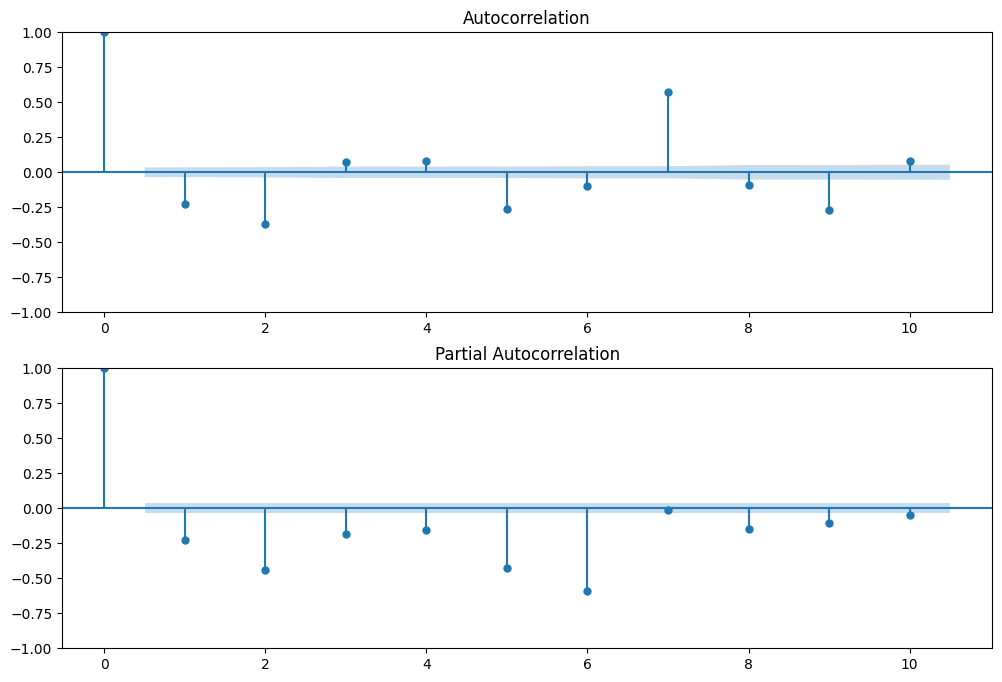

In [74]:
fig = plt.figure(figsize=(12,8))
# коррелограмма
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(pivot_diff_2.values.squeeze(), lags=10, ax=ax1)
# график частичной автокорреляции
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(pivot_diff_2, lags=10, ax=ax2)

# AR-МОДЕЛИРОВАНИЕ

In [197]:
# разделим данные на обучающую и тестовую выборки упорядоченно
test_df = pivot.iloc[-1]
train_df = pivot.iloc[:-1]
test_df

DAYTON    2168.0
Name: 2018-08-02 00:00:00, dtype: float64

In [198]:
 # экспоненциальное сглаживание
from statsmodels.tsa.api import SimpleExpSmoothing
ses = SimpleExpSmoothing(train_df)
alpha = 0.7
model = ses.fit(smoothing_level = alpha, optimized = False)
exp_pred = model.forecast(1)
exp_pred

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


2018-08-02    2048.762206
Freq: D, dtype: float64

In [199]:
# выбор р
p =7
len(train_df)

3135

In [200]:
# Инициализируем и обучим модель
from statsmodels.tsa.ar_model import AutoReg

ar_model = AutoReg(train_df, lags=p).fit()
print(ar_model.summary())

ar_pred = ar_model.predict(start=len(train_df), end=(len(pivot)-1), dynamic=False)
ar_pred

                            AutoReg Model Results                             
Dep. Variable:                 DAYTON   No. Observations:                 3135
Model:                     AutoReg(7)   Log Likelihood              -20055.555
Method:               Conditional MLE   S.D. of innovations            147.331
Date:                Fri, 03 Nov 2023   AIC                          40129.111
Time:                        17:38:21   BIC                          40183.544
Sample:                    01-08-2010   HQIC                         40148.649
                         - 08-01-2018                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        181.6810     24.183      7.513      0.000     134.283     229.079
DAYTON.L1      0.9521      0.018     53.463      0.000       0.917       0.987
DAYTON.L2     -0.4734      0.024    -19.636      0.0

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/deterministic.py:302: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Index with a unit increment support extending. The index is set will contain the position relative to the data length.
  fcast_index = self._extend_index(index, steps, forecast_index)


2018-08-02    2138.082317
Freq: D, dtype: float64

In [201]:
from sklearn.metrics import mean_squared_error

mean_squared_error(test_df, ar_pred) < mean_squared_error(test_df, exp_pred)

True

С помощью AR-МОДЕЛИРОВАНИЕ прогноз ближе к истинному значению, чем при экспоненциальном сглаживание

# ARIMA

<Figure size 1200x800 with 0 Axes>

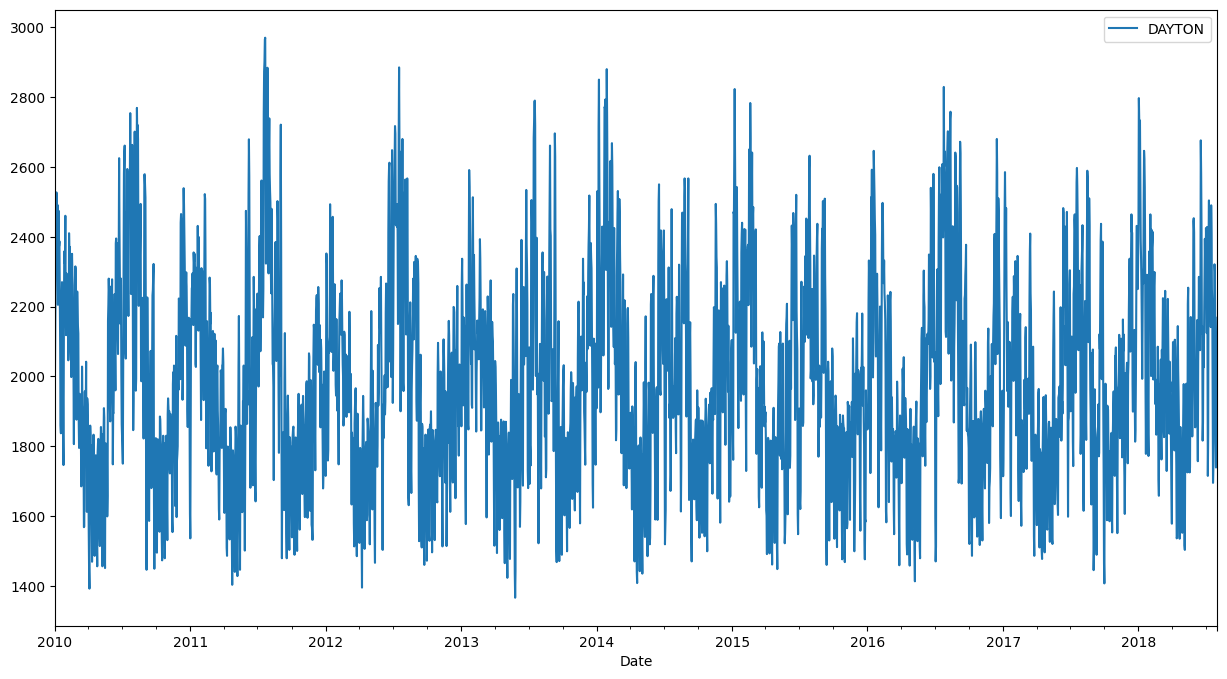

In [98]:
fig = plt.figure(figsize=(12,8))
pivot.plot()
plt.show()

In [215]:
train_df = pivot.loc[:'2018-06-30']
test_df = pivot.loc['2018-07-01':]
train_df.shape, test_df.shape

((3103, 1), (33, 1))

In [115]:
# разделим данные на обучающую и тестовую выборки упорядоченно
#test_df = pivot.iloc[-1]
#train_df = pivot.iloc[:-1]
#test_df

DAYTON    2168.0
Name: 2018-08-02 00:00:00, dtype: float64

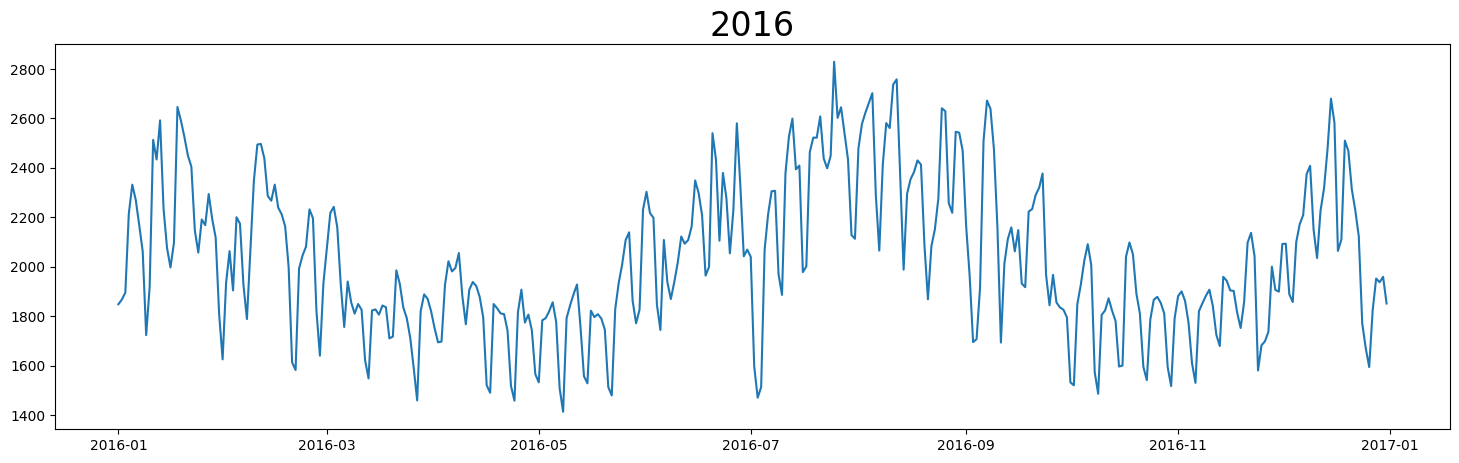

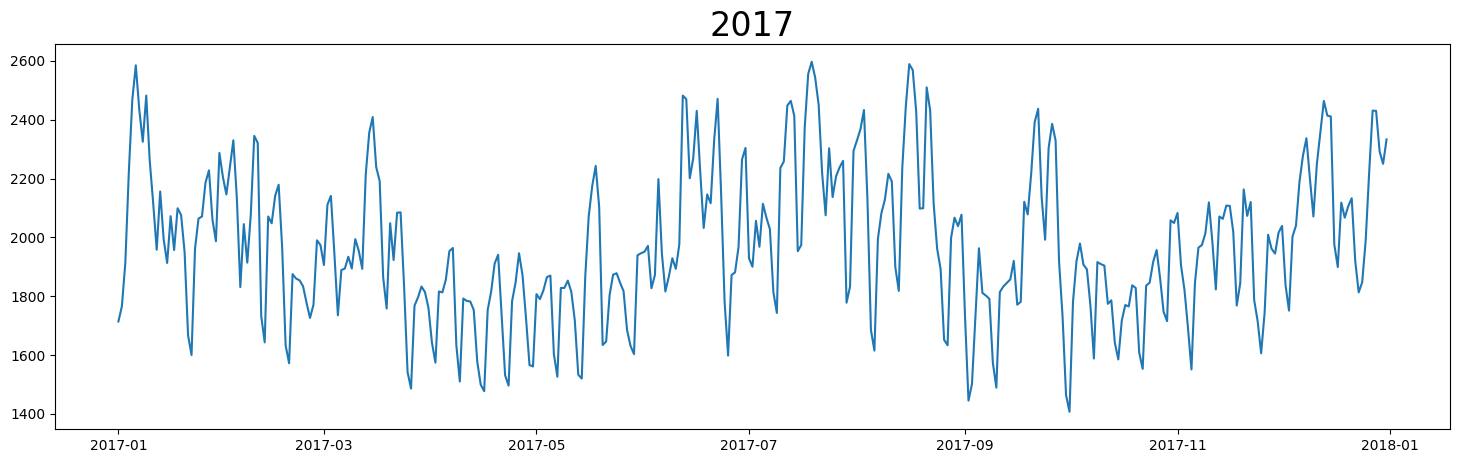

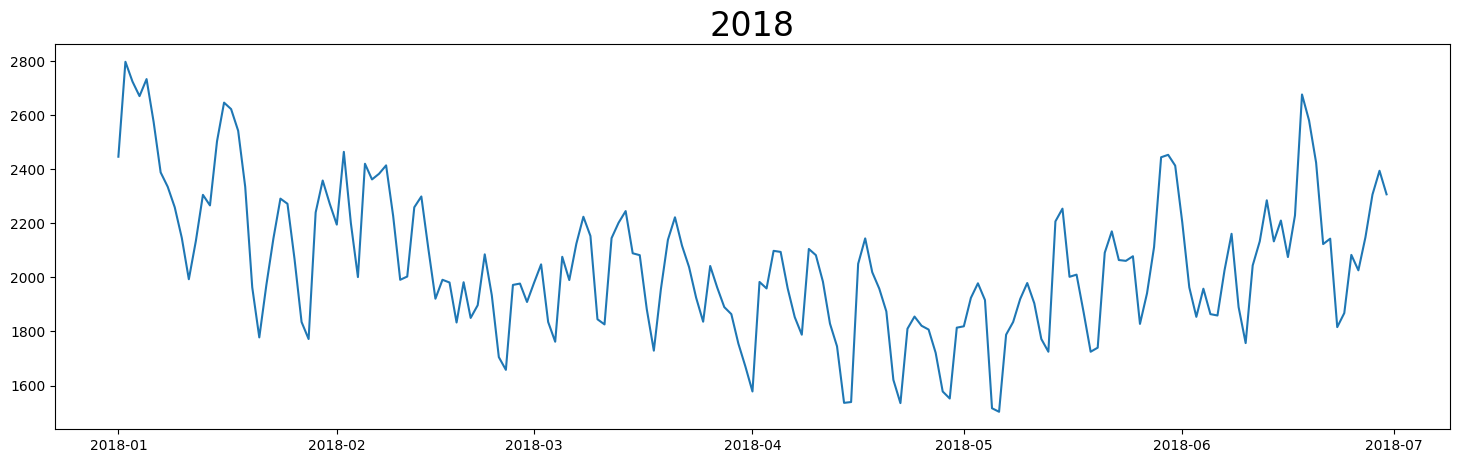

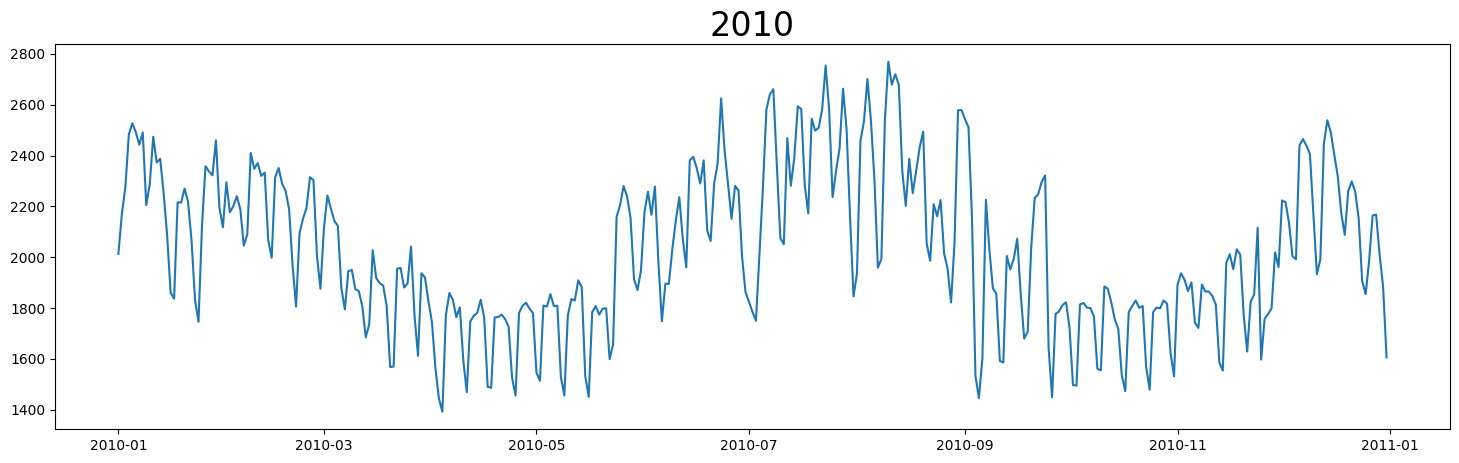

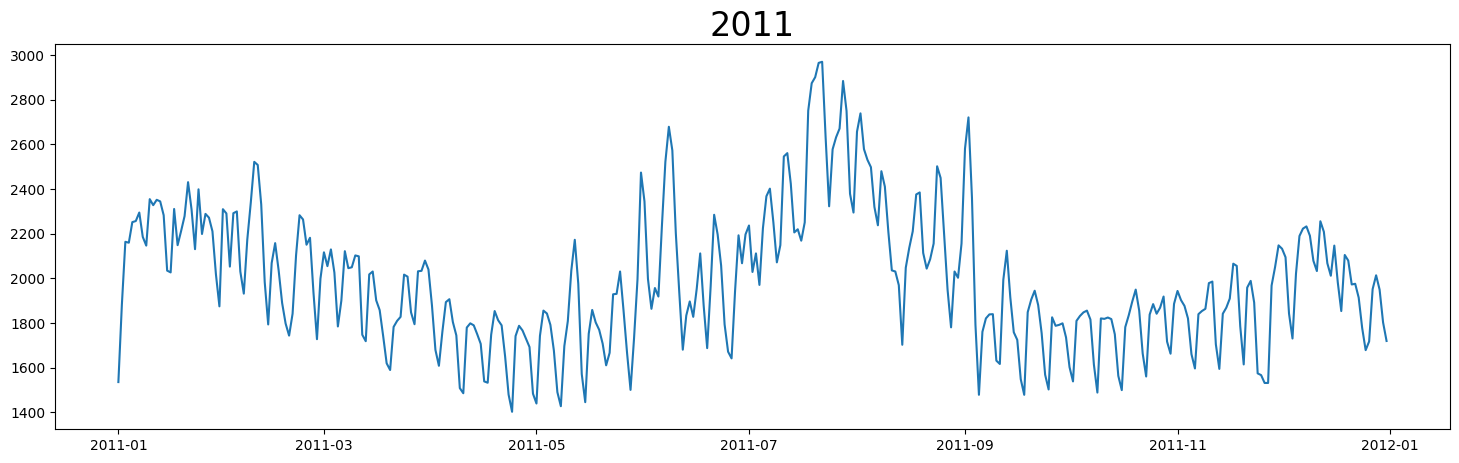

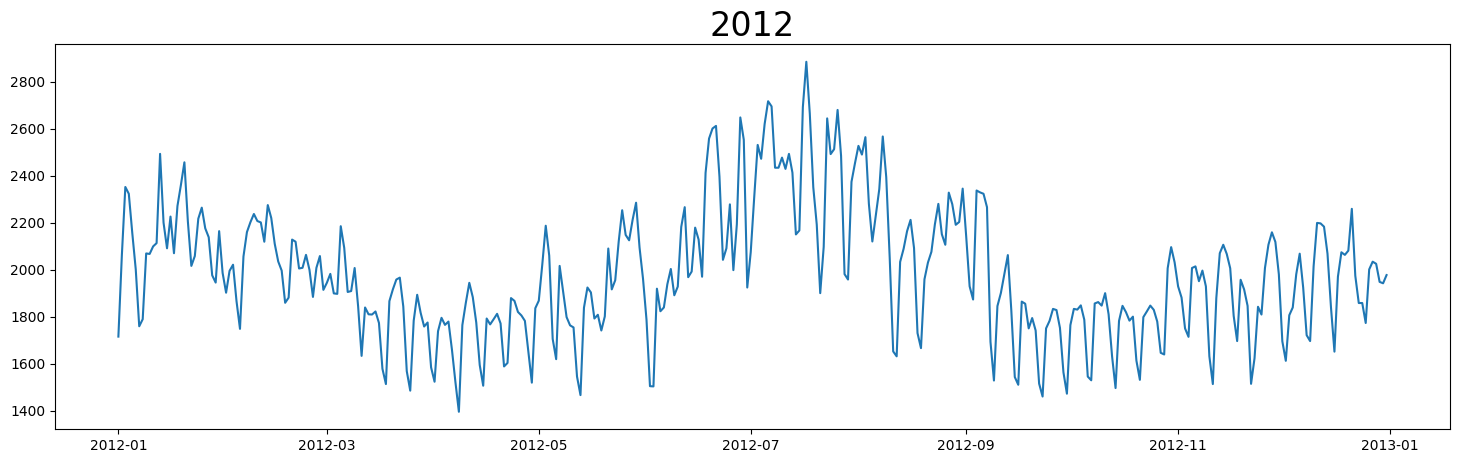

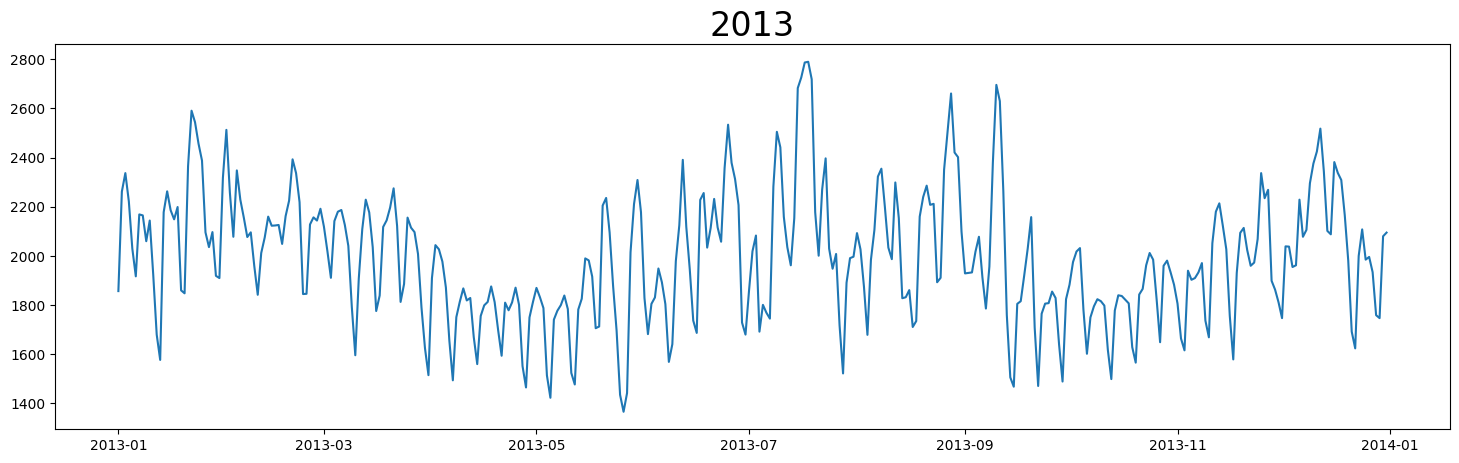

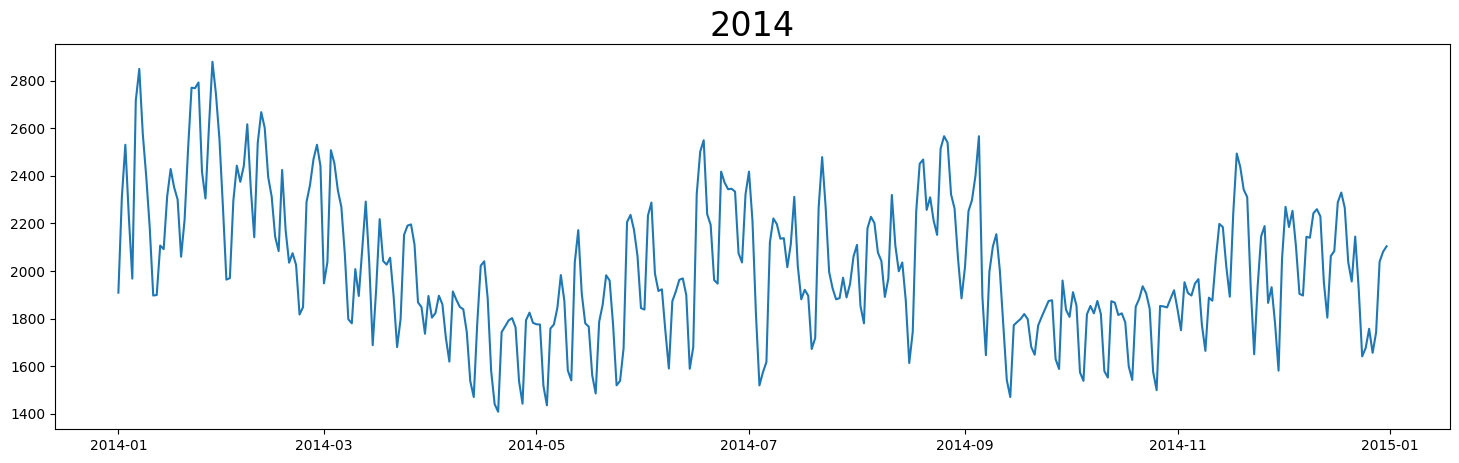

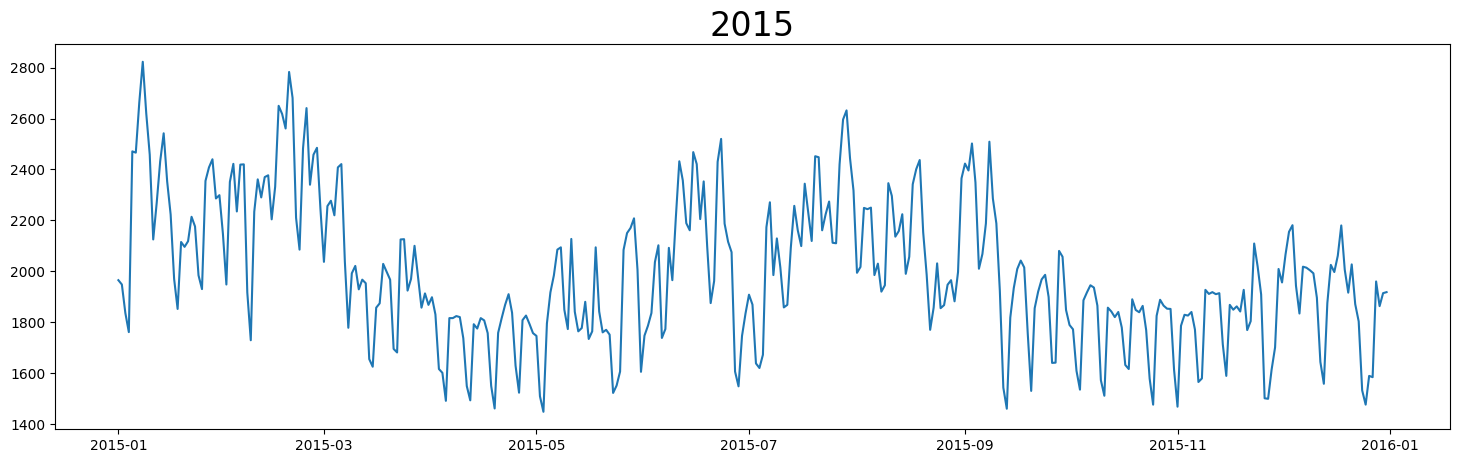

In [216]:
plt.rcParams["figure.figsize"] = 18, 5

for year in set(train_df.index.year):
    plt.plot(train_df[['DAYTON']].loc[train_df.index.year == year])
    plt.title(str(year), size=24)
    plt.show()

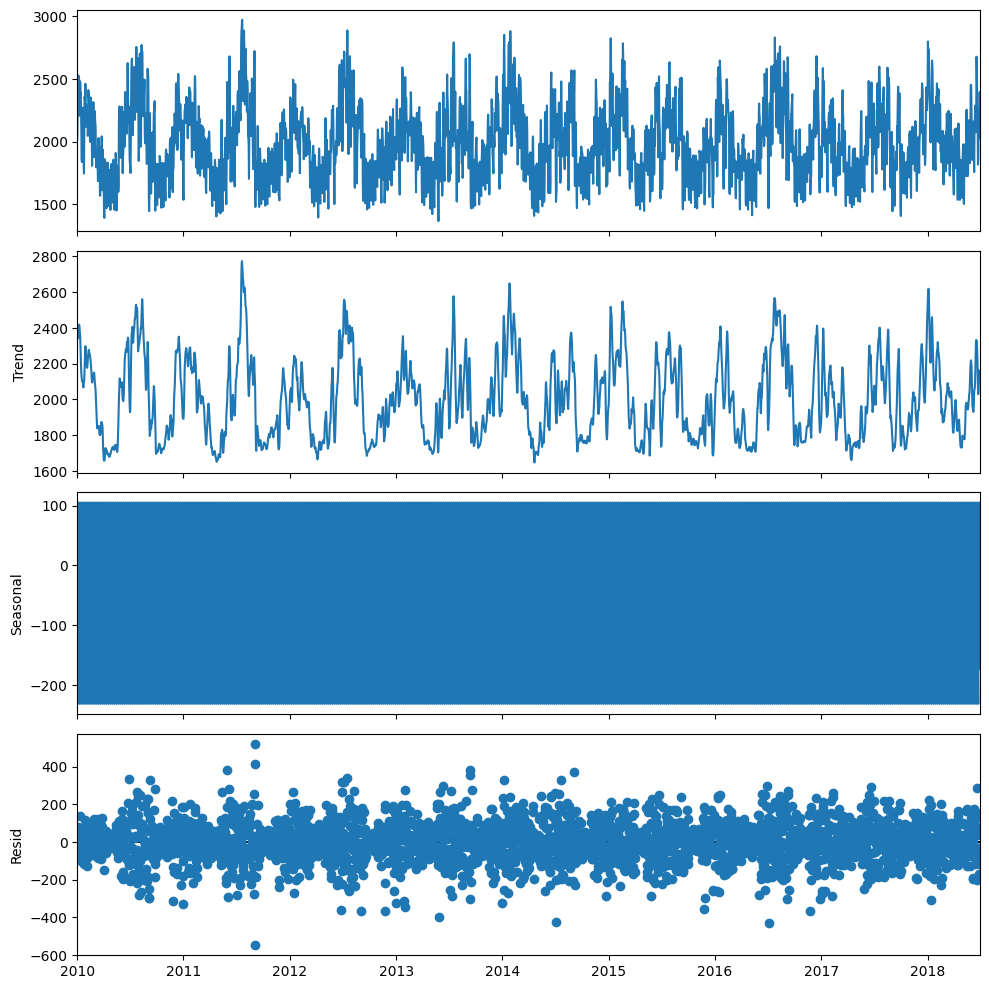

In [217]:
plt.rcParams["figure.figsize"] = 10, 10

result = seasonal_decompose(train_df)
result.plot()
plt.show()

Сезонная компонента выглядит очень странно, посмотрим на первые 20 значений

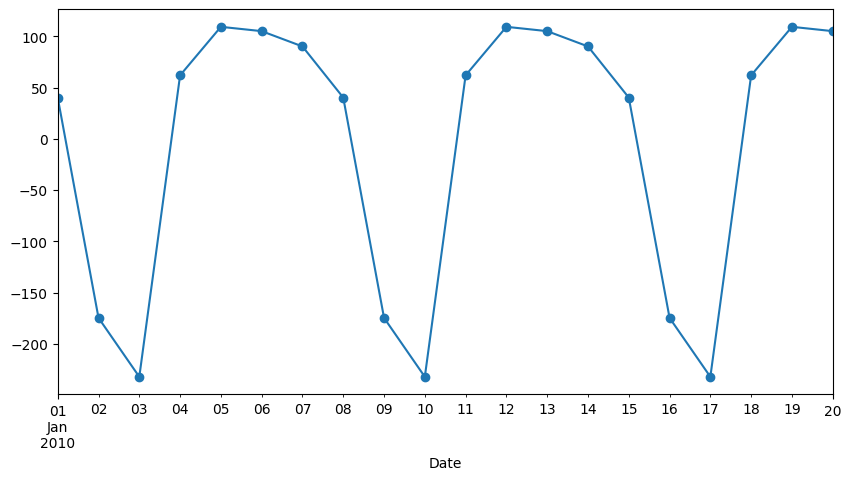

In [145]:
plt.rcParams["figure.figsize"] = 10, 5
result.seasonal[:20].plot(marker="o")
plt.show()

График четко показывает повторяющийся цикл каждые 7 периодов.  Это означает, что данные представляли собой еженедельную сезонность

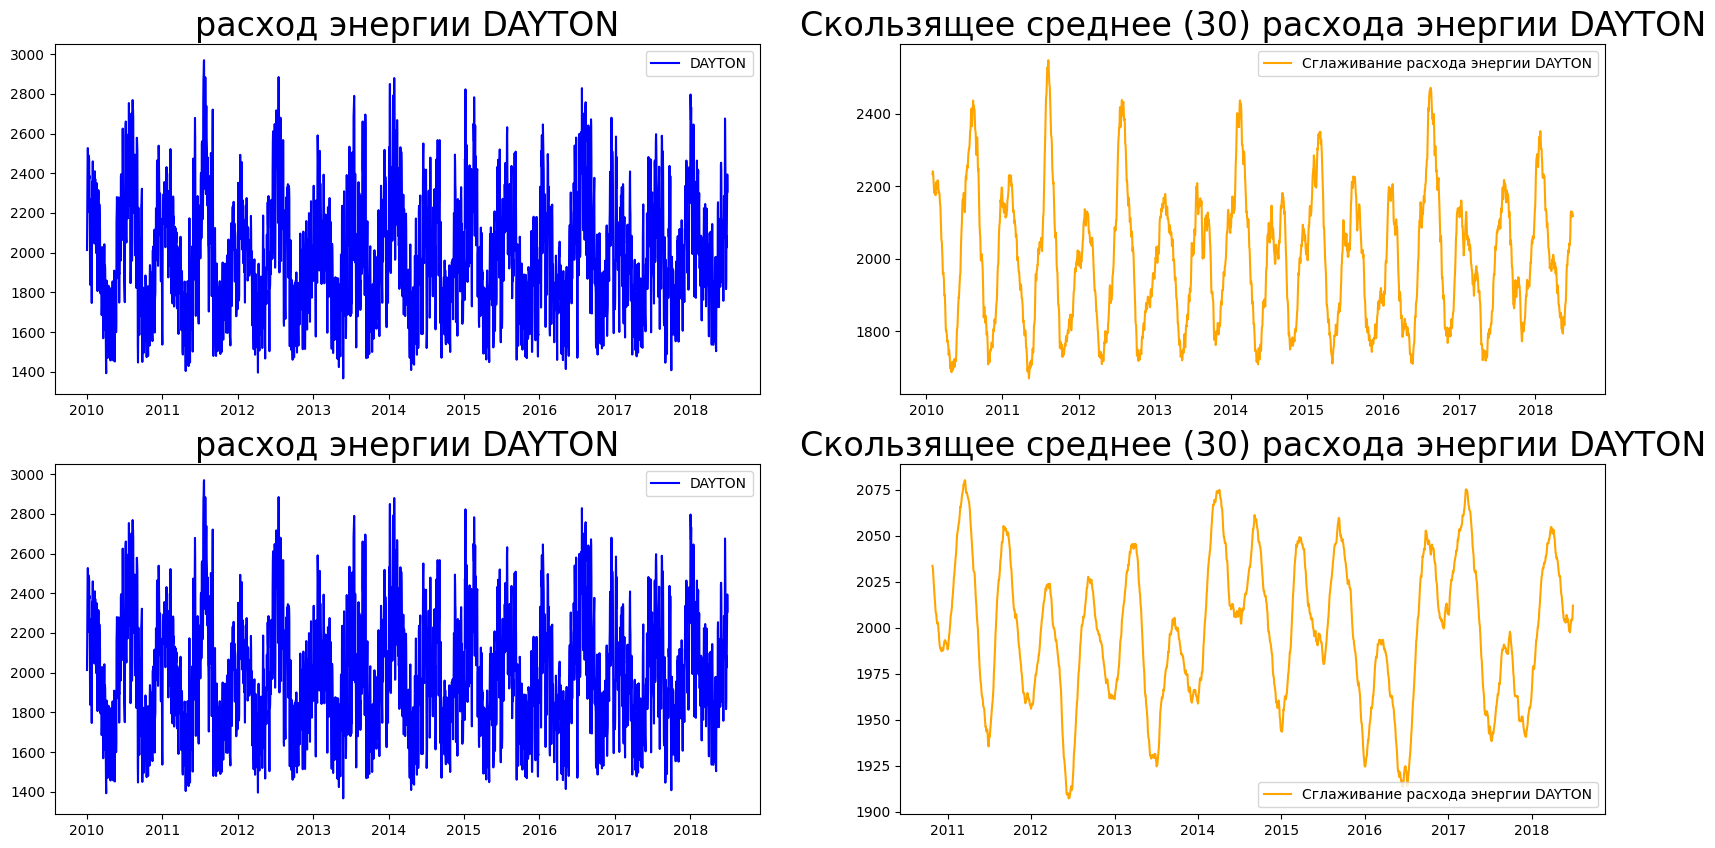

In [218]:
plt.rcParams["figure.figsize"] = 20, 10

fig, ax = plt.subplots(2, 2)

# Окно в месяц (Window = 30)
ax[0, 0].plot(train_df, color="blue", label="DAYTON")
ax[0, 0].set_title("расход энергии DAYTON", size=24)
ax[0, 0].legend()

ax[0, 1].plot(
    train_df.rolling(window=30).mean(),
    color="orange",
    label="Сглаживание расхода энергии DAYTON",
)

ax[0, 1].set_title("Скользящее среднее (30) расхода энергии DAYTON", size=24)
ax[0, 1].legend()


# Окно в год (Window = 300)
ax[1, 0].plot(train_df, color="blue", label="DAYTON")
ax[1, 0].set_title("расход энергии DAYTON", size=24)
ax[1, 0].legend()

ax[1, 1].plot(
    train_df.rolling(window=300).mean(),
    color="orange",
    label="Сглаживание расхода энергии DAYTON",
)

ax[1, 1].set_title("Скользящее среднее (30) расхода энергии DAYTON", size=24)
ax[1, 1].legend()

plt.show()

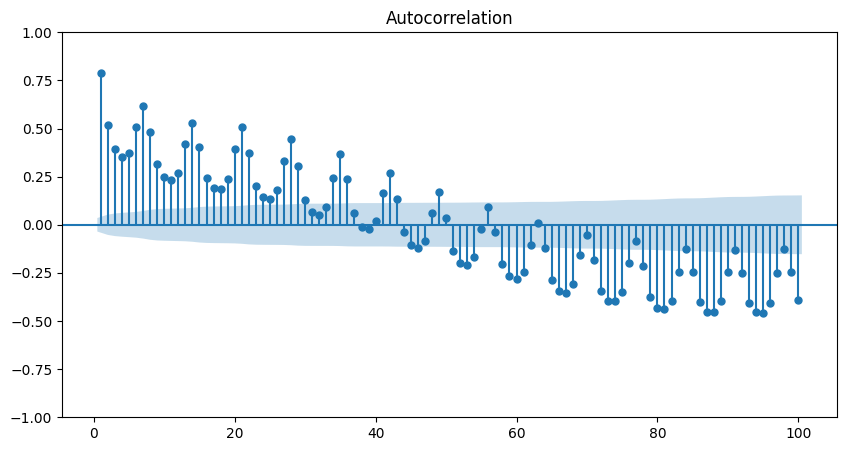

In [219]:
import statsmodels.graphics.tsaplots as sgt

plt.rcParams["figure.figsize"] = 10, 5
sgt.plot_acf(train_df, lags=100, zero=False)
plt.show()

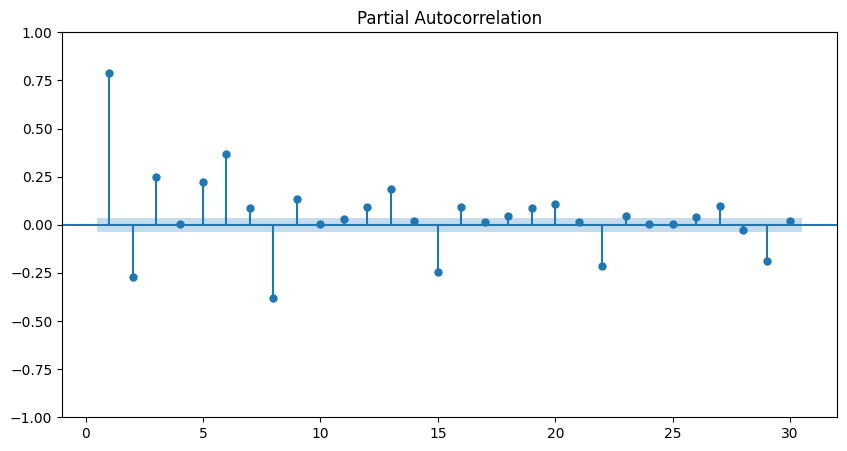

In [220]:
import statsmodels.graphics.tsaplots as sgt

plt.rcParams["figure.figsize"] = 10, 5
sgt.plot_pacf(train_df, lags=30, method="ywm", zero=False)
plt.show()

In [221]:
from statsmodels.tsa.stattools import adfuller

adfuller(train_df['DAYTON'])

(-6.525612165814402,
 1.016437970385822e-08,
 28,
 3074,
 {'1%': -3.432479072558126,
  '5%': -2.8624806901742885,
  '10%': -2.5672707526978216},
 38195.851423083746)

In [222]:
test1 = adfuller(train_df['DAYTON'])
print("adf: ", test1[0])
print("p-value: ", test1[1])
print("Critical values: ", test1[4])
if test1[0] > test1[4]["5%"]:
    print("ряд нестационарен")
else:
    print("ряд стационарен")

adf:  -6.525612165814402
p-value:  1.016437970385822e-08
Critical values:  {'1%': -3.432479072558126, '5%': -2.8624806901742885, '10%': -2.5672707526978216}
ряд стационарен


In [223]:
from statsmodels.tsa.arima.model import ARIMA

arima_model = ARIMA(train_df['DAYTON'].dropna(), order=(1, 0, 7))
arima_model_fit = arima_model.fit()
arima_model_fit.summary()

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                 DAYTON   No. Observations:                 3103
Model:                 ARIMA(1, 0, 7)   Log Likelihood              -19901.527
Date:                Fri, 03 Nov 2023   AIC                          39823.053
Time:                        17:42:40   BIC                          39883.455
Sample:                    01-01-2010   HQIC                         39844.742
                         - 06-30-2018                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       2002.1150     25.824     77.530      0.000    1951.501    2052.728
ar.L1          0.9423      0.010     90.775      0.000       0.922       0.963
ma.L1          0.0915      0.019      4.926      0.000       0.055       0.128
ma.L2         -0.3430      0.019    -18.465      0.000      -0.379      -0.307
ma.L3         -0.1918      0.018    -10.685      0.000      -0.227      -0.157
ma.L4         -0.1431      0.017     -8.334      0.000      -0.177      -0.109
ma.L5         -0.1877      0.018    -10.573      0.000      -0.223      -0.153
ma.L6         -0.0281      0.016     -1.721      0.085      -0.060       0.004
ma.L7          0.3304      0.016     20.271      0.000       0.298       0.362
sigma2      2.178e+04    487.649     44.663      0.000    2.08e+04    2.27e+04
===================================================================================
Ljung-Box (L1) (Q):                   0.25   Jarque-Bera (JB):               143.52
Prob(Q):                              0.61   Prob(JB):                         0.00
Heteroskedasticity (H):               1.03   Skew:                             0.34
Prob(H) (two-sided):                  0.62   Kurtosis:                         3.80
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [224]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

model = SARIMAX(train_df['DAYTON'].dropna(), order=(1, 0, 7))
model_fit = model.fit()
model_fit.summary()

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                 DAYTON   No. Observations:                 3103
Model:               SARIMAX(1, 0, 7)   Log Likelihood              -19928.223
Date:                Fri, 03 Nov 2023   AIC                          39874.447
Time:                        17:42:47   BIC                          39928.808
Sample:                    01-01-2010   HQIC                         39893.967
                         - 06-30-2018                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9998      0.000   2490.683      0.000       0.999       1.001
ma.L1          0.0550      0.017      3.249      0.001       0.022       0.088
ma.L2         -0.3870      0.016    -23.735      0.000      -0.419      -0.355
ma.L3         -0.2299      0.017    -13.280      0.000      -0.264      -0.196
ma.L4         -0.1765      0.017    -10.520      0.000      -0.209      -0.144
ma.L5         -0.2196      0.017    -12.577      0.000      -0.254      -0.185
ma.L6         -0.0584      0.016     -3.680      0.000      -0.089      -0.027
ma.L7          0.3174      0.016     19.933      0.000       0.286       0.349
sigma2      2.211e+04    480.035     46.064      0.000    2.12e+04    2.31e+04
===================================================================================
Ljung-Box (L1) (Q):                   0.05   Jarque-Bera (JB):               129.65
Prob(Q):                              0.82   Prob(JB):                         0.00
Heteroskedasticity (H):               1.03   Skew:                             0.27
Prob(H) (two-sided):                  0.60   Kurtosis:                         3.84
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [225]:
seas_model = SARIMAX(
    train_df['DAYTON'].dropna(), order=(1, 0, 1), seasonal_order=(1, 0, 1, 7)
)

seas_model_fit = seas_model.fit()
seas_model_fit.summary()

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                     
=========================================================================================
Dep. Variable:                            DAYTON   No. Observations:                 3103
Model:             SARIMAX(1, 0, 1)x(1, 0, 1, 7)   Log Likelihood              -19114.203
Date:                           Fri, 03 Nov 2023   AIC                          38238.406
Time:                                   17:42:54   BIC                          38268.607
Sample:                               01-01-2010   HQIC                         38249.251
                                    - 06-30-2018                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.8361      0.010     80.957      0.000       0.816       0.856
ma.L1          0.2785      0.016     17.764      0.000       0.248       0.309
ar.S.L7        1.0000    2.8e-06   3.57e+05      0.000       1.000       1.000
ma.S.L7       -0.9970      0.005   -196.502      0.000      -1.007      -0.987
sigma2      1.291e+04   8.13e-08   1.59e+11      0.000    1.29e+04    1.29e+04
===================================================================================
Ljung-Box (L1) (Q):                   1.22   Jarque-Bera (JB):               658.76
Prob(Q):                              0.27   Prob(JB):                         0.00
Heteroskedasticity (H):               0.96   Skew:                             0.27
Prob(H) (two-sided):                  0.46   Kurtosis:                         5.19
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 6.75e+25. Standard errors may be unstable.
"""

In [226]:
pred_df = pd.DataFrame(index=pivot.index)

pred_df["model_preds"] = seas_model_fit.predict(
    start=test_df.index[0], end=test_df.index[-1]
)


pred_df['DAYTON'] = pivot['DAYTON']

forecast = seas_model_fit.get_forecast(len(test_df.index))
forecast_df = forecast.conf_int(alpha=0.05)  # Confidence level of 95%

pred_df.at[test_df.index, "model_preds_lower"] = forecast_df['lower DAYTON']
pred_df.at[test_df.index, "model_preds_upper"] = forecast_df["upper DAYTON"]

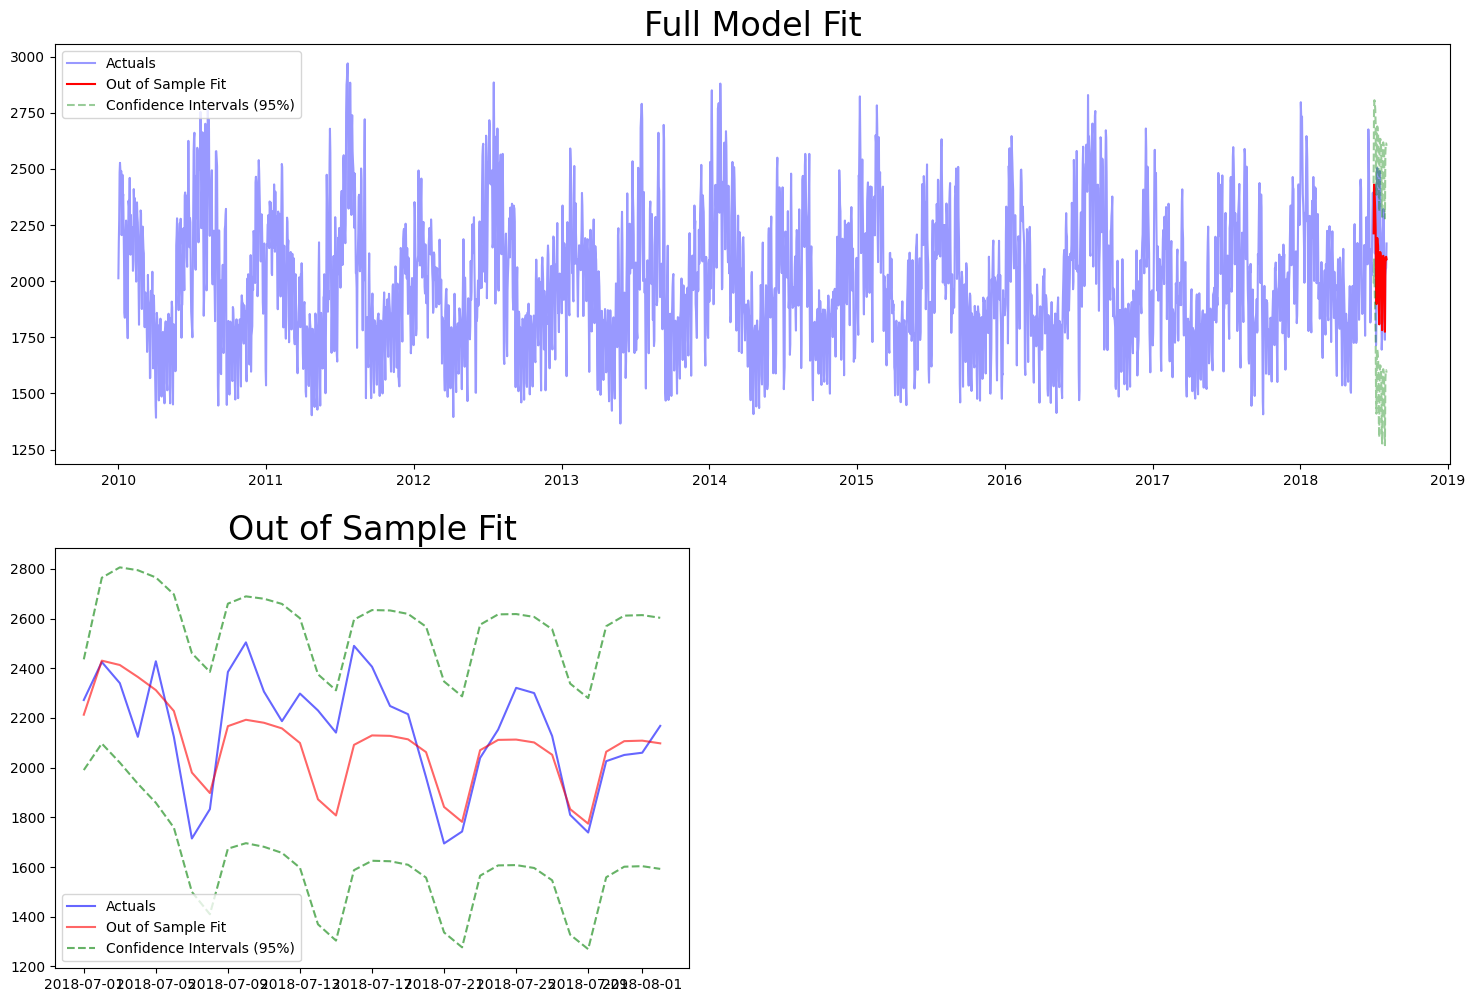

In [227]:
plt.rcParams["figure.figsize"] = 18, 12

plt.subplot(2, 1, 1)
plt.plot(pred_df['DAYTON'], color="blue", label="Actuals", alpha=0.4)

plt.plot(
    pred_df.loc[test_df.index]["model_preds"],
    color="red",
    linestyle="-",
    label="Out of Sample Fit",
)

plt.plot(
    pred_df.loc[test_df.index]["model_preds_lower"],
    color="green",
    linestyle="--",
    label="Confidence Intervals (95%)",
    alpha=0.4,
)

plt.plot(
    pred_df.loc[test_df.index]["model_preds_upper"],
    color="green",
    linestyle="--",
    alpha=0.4,
)

plt.title("Full Model Fit", size=24)
plt.legend()

plt.subplot(2, 2, 3)

plt.plot(
    pred_df.loc[test_df.index]['DAYTON'], color="blue", label="Actuals", alpha=0.6
)

plt.plot(
    pred_df.loc[test_df.index]["model_preds"],
    color="red",
    linestyle="-",
    label="Out of Sample Fit",
    alpha=0.6,
)

plt.plot(
    pred_df.loc[test_df.index]["model_preds_lower"],
    color="green",
    linestyle="--",
    label="Confidence Intervals (95%)",
    alpha=0.6,
)

plt.plot(
    pred_df.loc[test_df.index]["model_preds_upper"],
    color="green",
    linestyle="--",
    alpha=0.6,
)

plt.title("Out of Sample Fit", size=24)
plt.legend()

plt.show()

In [157]:
!pip install pmdarima
import pmdarima as pm

smodel = pm.auto_arima(
    train_df,
    start_p=1,
    d=0,
    start_q=1,
    max_p=5,
    max_q=5,
    D=1,
    start_P=0,
    m=7,
    test="adf",
    error_action="ignore",
    trace=True,
)

smodel.summary()

  Using cached pmdarima-2.0.4-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.manylinux_2_28_x86_64.whl (2.1 MB)
Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,1,1)[7] intercept   : AIC=inf, Time=6.30 sec
 ARIMA(0,0,0)(0,1,0)[7] intercept   : AIC=30244.663, Time=0.16 sec
 ARIMA(1,0,0)(1,1,0)[7] intercept   : AIC=27816.830, Time=8.62 sec
 ARIMA(0,0,1)(0,1,1)[7] intercept   : AIC=28081.145, Time=5.18 sec
 ARIMA(0,0,0)(0,1,0)[7]             : AIC=30242.791, Time=0.24 sec
 ARIMA(1,0,0)(0,1,0)[7] intercept   : AIC=28403.218, Time=0.63 sec
 ARIMA(1,0,0)(2,1,0)[7] intercept   : AIC=27512.424, Time=17.40 sec
 ARIMA(1,0,0)(2,1,1)[7] intercept   : AIC=inf, Time=13.50 sec
 ARIMA(1,0,0)(1,1,1)[7] intercept   : AIC=inf, Time=6.56 sec
 ARIMA(0,0,0)(2,1,0)[7] intercept   : AIC=29710.542, Time=3.94 sec
 ARIMA(2,0,0)(2,1,0)[7] intercept   : AIC=27380.438, Time=9.59 sec
 ARIMA(2,0,0)(1,1,0)[7] intercept   : AIC=27653.737, Time=3.94 sec
 ARIMA(2,0,0)(2,1,1)[7] intercept   : AIC=inf, Ti

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                     
=========================================================================================
Dep. Variable:                                 y   No. Observations:                 2191
Model:             SARIMAX(3, 0, 0)x(2, 1, 0, 7)   Log Likelihood              -13666.561
Date:                           Fri, 03 Nov 2023   AIC                          27345.122
Time:                                   17:14:48   BIC                          27379.255
Sample:                               01-01-2010   HQIC                         27357.599
                                    - 12-31-2015                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.0300      0.017     59.402      0.000       0.996       1.064
ar.L2         -0.3715      0.025    -15.013      0.000      -0.420      -0.323
ar.L3          0.1274      0.019      6.647      0.000       0.090       0.165
ar.S.L7       -0.6546      0.018    -37.275      0.000      -0.689      -0.620
ar.S.L14      -0.3588      0.017    -20.553      0.000      -0.393      -0.325
sigma2      1.593e+04    366.709     43.443      0.000    1.52e+04    1.66e+04
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):               245.78
Prob(Q):                              0.96   Prob(JB):                         0.00
Heteroskedasticity (H):               1.02   Skew:                             0.14
Prob(H) (two-sided):                  0.77   Kurtosis:                         4.62
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [228]:
seas_model_1 = SARIMAX(
    train_df['DAYTON'].dropna(), order=(3, 0, 0), seasonal_order=(2, 1, 0, 7)
)

seas_model_fit_1 = seas_model_1.fit()
seas_model_fit_1.summary()

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                     
=========================================================================================
Dep. Variable:                            DAYTON   No. Observations:                 3103
Model:             SARIMAX(3, 0, 0)x(2, 1, 0, 7)   Log Likelihood              -19390.256
Date:                           Fri, 03 Nov 2023   AIC                          38792.513
Time:                                   17:43:20   BIC                          38828.740
Sample:                               01-01-2010   HQIC                         38805.523
                                    - 06-30-2018                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.0313      0.015     69.071      0.000       1.002       1.061
ar.L2         -0.3490      0.022    -16.084      0.000      -0.392      -0.306
ar.L3          0.1042      0.016      6.371      0.000       0.072       0.136
ar.S.L7       -0.6498      0.015    -43.345      0.000      -0.679      -0.620
ar.S.L14      -0.3406      0.014    -23.557      0.000      -0.369      -0.312
sigma2      1.611e+04    315.407     51.081      0.000    1.55e+04    1.67e+04
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):               313.05
Prob(Q):                              0.97   Prob(JB):                         0.00
Heteroskedasticity (H):               1.02   Skew:                             0.12
Prob(H) (two-sided):                  0.77   Kurtosis:                         4.54
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [229]:
pred_df_1 = pd.DataFrame(index=pivot.index)

pred_df_1["model_preds"] = seas_model_fit_1.predict(
    start=test_df.index[0], end=test_df.index[-1]
)


pred_df_1['DAYTON'] = pivot['DAYTON']

forecast_1 = seas_model_fit_1.get_forecast(len(test_df.index))
forecast_df_1 = forecast_1.conf_int(alpha=0.05)  # Confidence level of 95%

pred_df_1.at[test_df.index, "model_preds_lower"] = forecast_df_1['lower DAYTON']
pred_df_1.at[test_df.index, "model_preds_upper"] = forecast_df_1["upper DAYTON"]

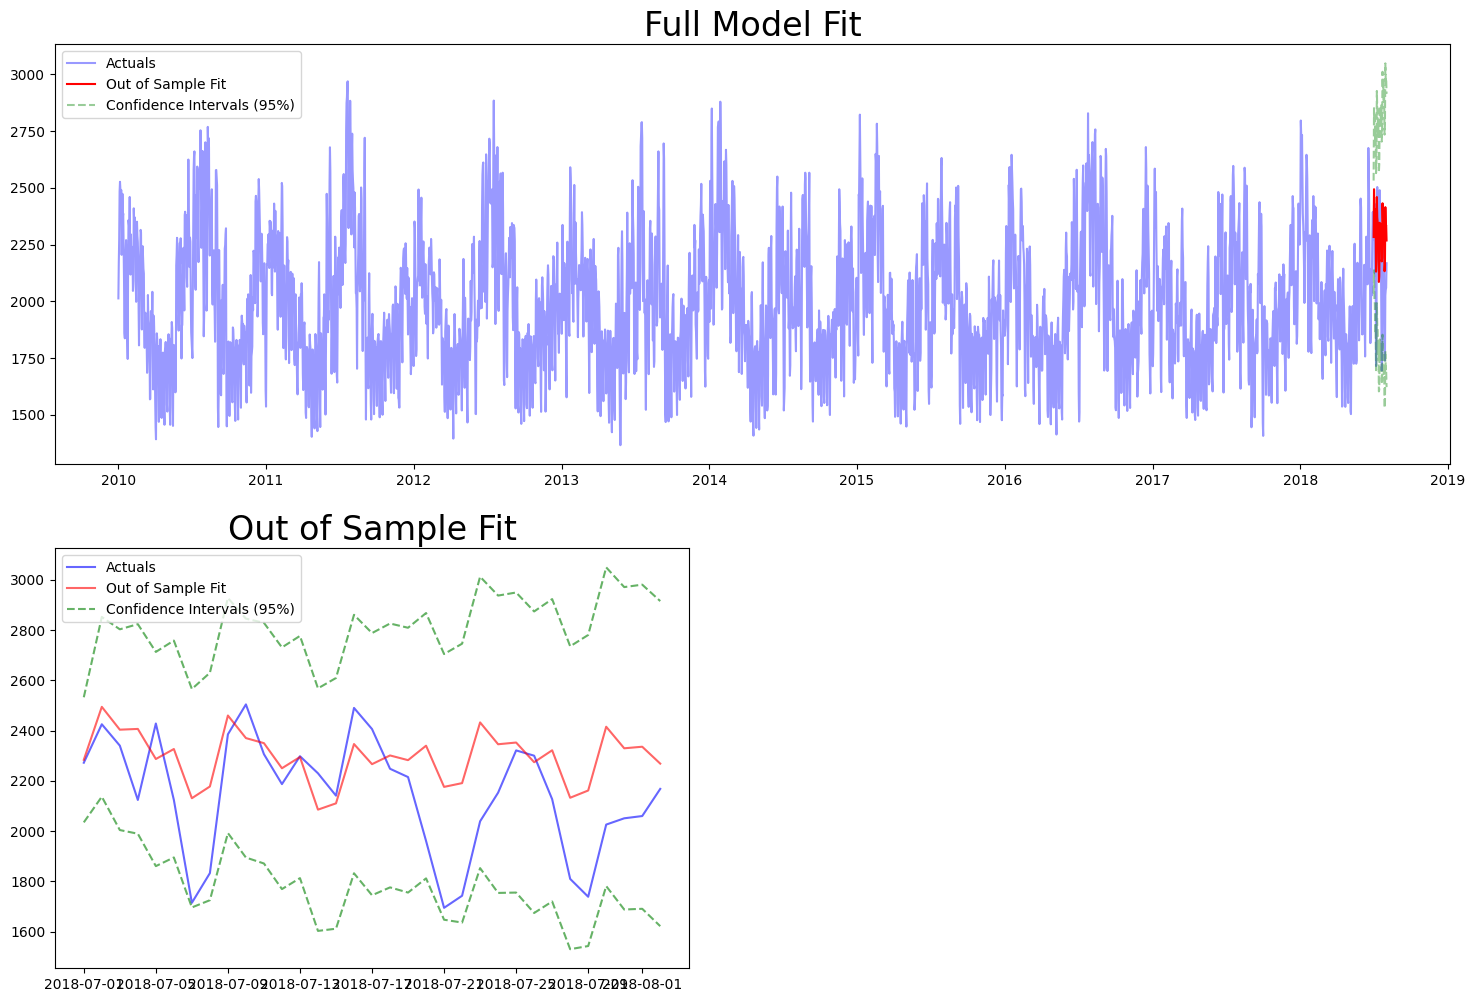

In [233]:
plt.rcParams["figure.figsize"] = 18, 12

plt.subplot(2, 1, 1)
plt.plot(pred_df_1['DAYTON'], color="blue", label="Actuals", alpha=0.4)

plt.plot(
    pred_df_1.loc[test_df.index]["model_preds"],
    color="red",
    linestyle="-",
    label="Out of Sample Fit",
)

plt.plot(
    pred_df_1.loc[test_df.index]["model_preds_lower"],
    color="green",
    linestyle="--",
    label="Confidence Intervals (95%)",
    alpha=0.4,
)

plt.plot(
    pred_df_1.loc[test_df.index]["model_preds_upper"],
    color="green",
    linestyle="--",
    alpha=0.4,
)

plt.title("Full Model Fit", size=24)
plt.legend()

plt.subplot(2, 2, 3)

plt.plot(
    pred_df_1.loc[test_df.index]['DAYTON'], color="blue", label="Actuals", alpha=0.6
)

plt.plot(
    pred_df_1.loc[test_df.index]["model_preds"],
    color="red",
    linestyle="-",
    label="Out of Sample Fit",
    alpha=0.6,
)

plt.plot(
    pred_df_1.loc[test_df.index]["model_preds_lower"],
    color="green",
    linestyle="--",
    label="Confidence Intervals (95%)",
    alpha=0.6,
)

plt.plot(
    pred_df_1.loc[test_df.index]["model_preds_upper"],
    color="green",
    linestyle="--",
    alpha=0.6,
)

plt.title("Out of Sample Fit", size=24)
plt.legend()

plt.show()

При выборе наилучших параметров с помощью пакета pmdarima Best model:  ARIMA(3,0,0)(2,1,0)[7] 95%-ый доверительный интервал для прогноза в некоторых точках равен исходным данным

# Prophet

In [286]:
# Импортируем Prophet
from prophet import Prophet

In [274]:
dff = fill_data_copy. reset_index()
dff

,Datetime,AEP,DAYTON,DOM,DUQ,PJME,PJMW,Date
0,2010-01-01 00:00:00,15116.0,1794.0,10770.0,1526.0,31647.0,5381.0,2010-01-01
1,2010-12-31 01:00:00,14695.0,1553.0,11477.0,1495.0,29634.0,5278.0,2010-12-31
2,2010-12-31 02:00:00,14290.0,1483.0,11235.0,1439.0,28614.0,5131.0,2010-12-31
3,2010-12-31 03:00:00,13992.0,1439.0,11216.0,1401.0,28146.0,5056.0,2010-12-31
4,2010-12-31 04:00:00,13896.0,1418.0,11276.0,1390.0,28051.0,5050.0,2010-12-31
...,...,...,...,...,...,...,...,...
75249,2018-01-01 20:00:00,21089.0,2732.0,18418.0,1962.0,44284.0,8401.0,2018-01-01
75250,2018-01-01 21:00:00,20999.0,2724.0,18567.0,1940.0,43751.0,8373.0,2018-01-01
75251,2018-01-01 22:00:00,20820.0,2664.0,18307.0,1891.0,42402.0,8238.0,2018-01-01
75252,2018-01-01 23:00:00,20415.0,2614.0,17814.0,1820.0,40164.0,7958.0,2018-01-01


In [275]:
dff['Datetime'] = pd.to_datetime(dff['Datetime'], format='%Y-%m-%d')
dff['Datetime']=dff['Datetime'].dt.date
dff=dff.drop(['Date'],axis=1)
dff

,Datetime,AEP,DAYTON,DOM,DUQ,PJME,PJMW
0,2010-01-01,15116.0,1794.0,10770.0,1526.0,31647.0,5381.0
1,2010-12-31,14695.0,1553.0,11477.0,1495.0,29634.0,5278.0
2,2010-12-31,14290.0,1483.0,11235.0,1439.0,28614.0,5131.0
3,2010-12-31,13992.0,1439.0,11216.0,1401.0,28146.0,5056.0
4,2010-12-31,13896.0,1418.0,11276.0,1390.0,28051.0,5050.0
...,...,...,...,...,...,...,...
75249,2018-01-01,21089.0,2732.0,18418.0,1962.0,44284.0,8401.0
75250,2018-01-01,20999.0,2724.0,18567.0,1940.0,43751.0,8373.0
75251,2018-01-01,20820.0,2664.0,18307.0,1891.0,42402.0,8238.0
75252,2018-01-01,20415.0,2614.0,17814.0,1820.0,40164.0,7958.0


In [276]:
pivot=dff.pivot_table(
    values=['DAYTON'],
    index='Datetime',
    fill_value=0
).round()
df = pivot. reset_index()
df

,Datetime,DAYTON
0,2010-01-01,2013.0
1,2010-01-02,2170.0
2,2010-01-03,2275.0
3,2010-01-04,2483.0
4,2010-01-05,2527.0
...,...,...
3131,2018-07-29,1739.0
3132,2018-07-30,2026.0
3133,2018-07-31,2051.0
3134,2018-08-01,2060.0


In [277]:
df.columns = ['ds', 'y']
df

,ds,y
0,2010-01-01,2013.0
1,2010-01-02,2170.0
2,2010-01-03,2275.0
3,2010-01-04,2483.0
4,2010-01-05,2527.0
...,...,...
3131,2018-07-29,1739.0
3132,2018-07-30,2026.0
3133,2018-07-31,2051.0
3134,2018-08-01,2060.0


In [285]:
# Обучим модель на датасете:
model = Prophet()
model.fit(df)

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnz_bfitv/hsesfrzf.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnz_bfitv/xa04h0w7.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=19717', 'data', 'file=/tmp/tmpnz_bfitv/hsesfrzf.json', 'init=/tmp/tmpnz_bfitv/xa04h0w7.json', 'output', 'file=/tmp/tmpnz_bfitv/prophet_modelnj4qk7vo/prophet_model-20231103184332.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:43:32 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:43:33 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [290]:
# даты, для которых должен быть сделан прогноз
future_df = model.make_future_dataframe(periods=2)

future_df.tail()

,ds
3133,2018-07-31
3134,2018-08-01
3135,2018-08-02
3136,2018-08-03
3137,2018-08-04


In [287]:
pivot

,DAYTON
Datetime,
2010-01-01,2013.0
2010-01-02,2170.0
2010-01-03,2275.0
2010-01-04,2483.0
2010-01-05,2527.0
...,...
2018-07-29,1739.0
2018-07-30,2026.0
2018-07-31,2051.0


In [291]:
# ('yhat_lower', 'yhat_upper'), в которых будут находиться верхняя и нижняя границы доверительного интервала
forecast_df = model.predict(future_df)
forecast_df[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
3133,2018-07-31,2384.567481,2139.936143,2617.678910
3134,2018-08-01,2376.156549,2156.067691,2595.525568
3135,2018-08-02,2356.367116,2113.225550,2581.620881
3136,2018-08-03,2297.284437,2051.131151,2513.798478
3137,2018-08-04,2070.785282,1848.406705,2319.267949


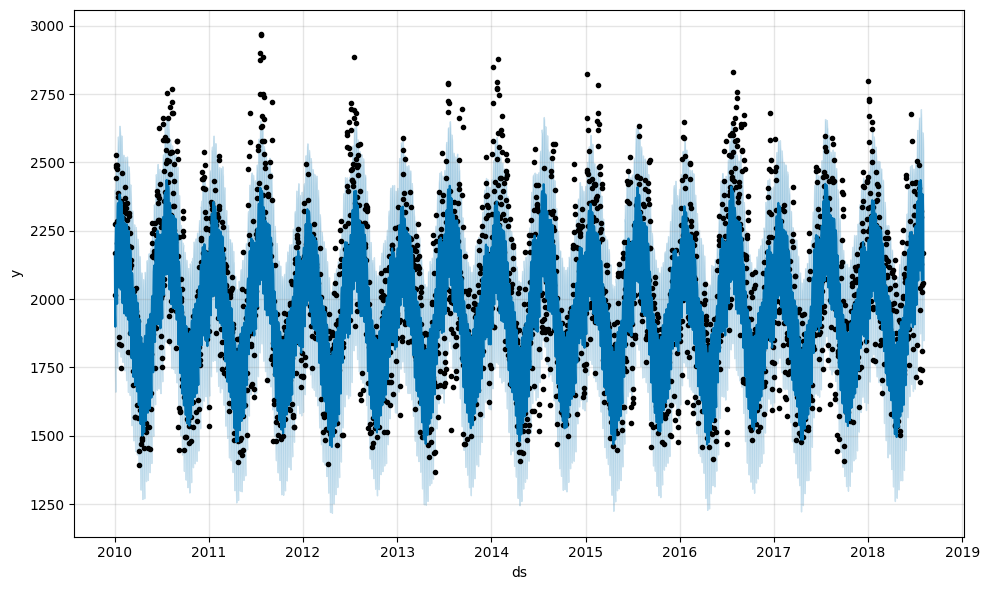

In [282]:
fig = model.plot(forecast_df) # отобразить прогноз

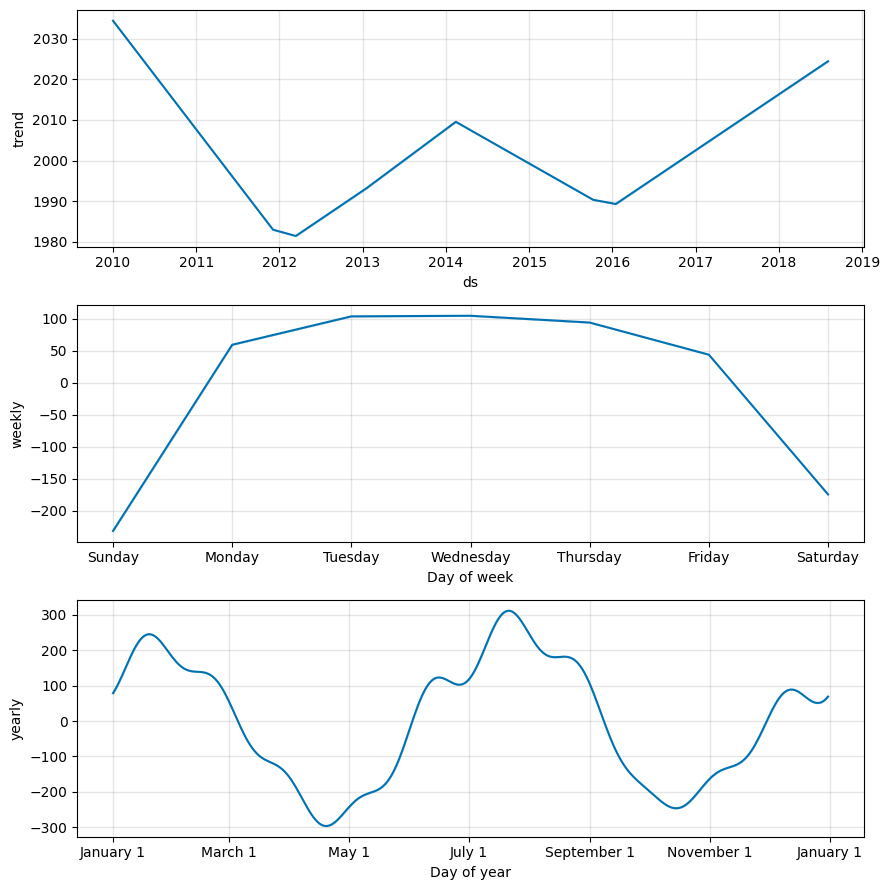

In [283]:
fig = model.plot_components(forecast_df) # компоненты ряда

Прогноз с помощью Prophet показал завышенные данные.